<span style="background-color:#f6f8fa">last updated : 2023-Feb-24 / Daegun Kim (daegunkim0425@gmail.com)</span>

# EDA BRAX
- **Dataset URL:** https://physionet.org/content/brax/1.1.0/
- This notebook is written based on brax-a-brazilian-labeled-chest-x-ray-dataset-1.1.0

> ### Table of contents
> 1. [Explore CSV files](#1)
> 2. [Explore Images](#2)

In [1]:
import os
import pandas as pd
from glob import glob
import seaborn as sns
from copy import deepcopy
import math
import random

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

# 1. Explore CSV files

## 1.1 Load CSV and Simple Check

In [2]:
root_dir = '/home/brax-a-brazilian-labeled-chest-x-ray-dataset-1.1.0/'
df = pd.read_csv(os.path.join(root_dir, 'master_spreadsheet_update.csv'), index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40967 entries, 0 to 40966
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DicomPath                   40967 non-null  object 
 1   PngPath                     40967 non-null  object 
 2   PatientID                   40967 non-null  object 
 3   PatientSex                  40967 non-null  object 
 4   PatientAge                  40967 non-null  object 
 5   AccessionNumber             40967 non-null  int64  
 6   StudyDate                   40967 non-null  int64  
 7   No Finding                  40967 non-null  float64
 8   Enlarged Cardiomediastinum  26285 non-null  float64
 9   Cardiomegaly                31984 non-null  float64
 10  Lung Lesion                 1355 non-null   float64
 11  Lung Opacity                4134 non-null   float64
 12  Edema                       50 non-null     float64
 13  Consolidation               317

In [4]:
df.head(1).T

0
DicomPath                   Anonymized_DICOMs/id_55c25711-75a21898-593e2ee...
PngPath                     images/id_55c25711-75a21898-593e2eea-46007548-...
PatientID                     id_55c25711-75a21898-593e2eea-46007548-5afa539c
PatientSex                                                                  M
PatientAge                                                                 40
AccessionNumber                                                      79565147
StudyDate                                                            20101129
No Finding                                                                1.0
Enlarged Cardiomediastinum                                                0.0
Cardiomegaly                                                              0.0
Lung Lesion                                                               NaN
Lung Opacity                                                              NaN
Edema                                                                     NaN
Consolidation                                                             NaN
Pneumonia                                                                 NaN
Atelectasis                                                               NaN
Pneumothorax                                                              NaN
Pleural Effusion                                                          0.0
Pleural Other                                                             NaN
Fracture                                                                  NaN
Support Devices                                                           1.0
ViewPosition                                                                L
Rows                                                                     3001
Columns                                                                  1862
Manufacturer                                                                5

##### Key observations
* Data size (40,967) is much smaller compare to the CheXpert and MIMIC.
* There is only one CSV file in BRAX dataset **(There is no explicit split information)**
* There is the png path column so no need for concatenate several paths to find the image path
* There are the Manufacturer values that are not in either both CheXpert or MIMIC

## 1.2 Check missing values

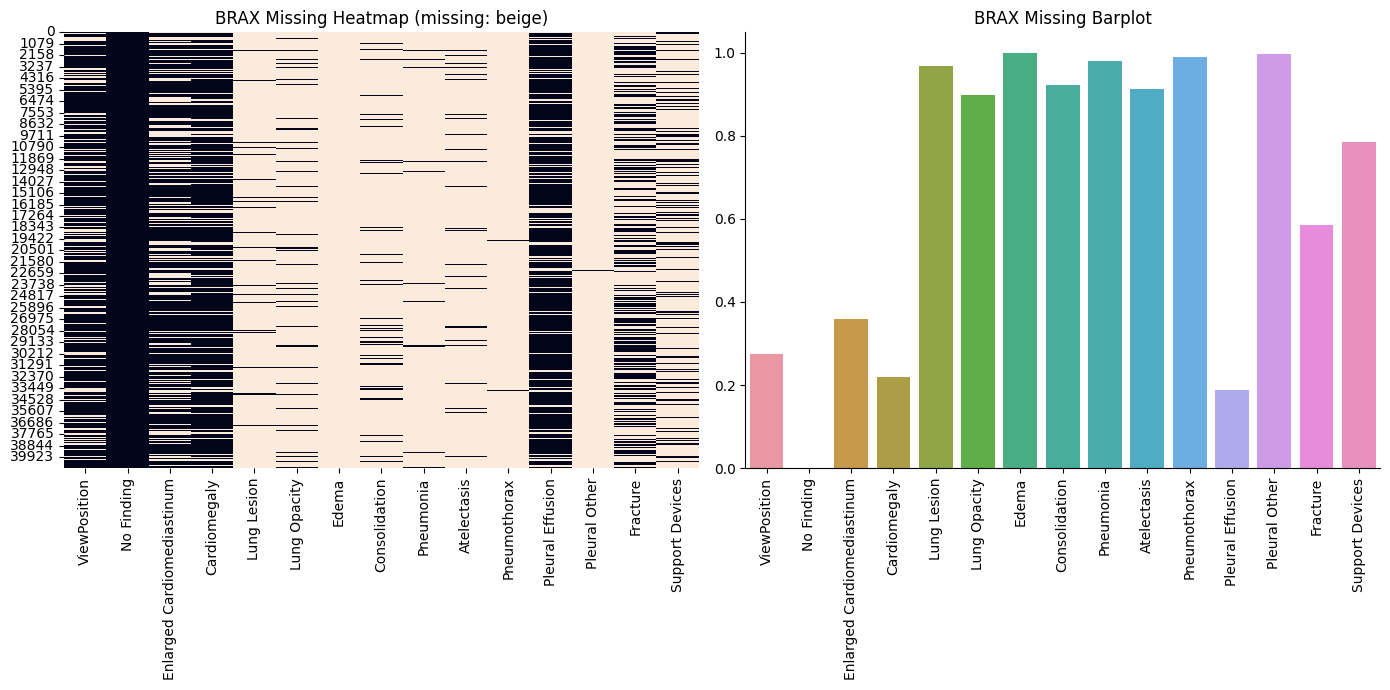

In [5]:
focus_cols = ['ViewPosition', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Lesion',
       'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

fig_ms_heat, ax_ms_heat = plt.subplots(1, 2, figsize=(14, 7))

sns.heatmap(df[focus_cols].isnull(), cbar=False, square=False, ax=ax_ms_heat[0])
ax1 = sns.barplot(df[focus_cols].isnull(), ax=ax_ms_heat[1], errorbar=None)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax_ms_heat[0].set_title('BRAX Missing Heatmap (missing: beige)')
ax_ms_heat[1].set_title('BRAX Missing Barplot')
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)

fig_ms_heat.tight_layout()

##### Key observations
* Most of every pathological column is missing
  - Only the four columns (No Finding, Enlarged Cardiomediastinum, Cardiomegaly, and Pleural Effusion) has less then half of missing values
* More than one-fifth of view positions are missing, and the amount is hard to neglect

## 1.3 Visualize Target class distribution labels in each dataset

In [6]:
target_cols = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

pathology_cols = [v for v in target_cols if v not in ['No Finding', 'Support Devices']]

def calculate_label(df: pd.DataFrame, ratio=False, include_nan=True):
    series_nan = df.isnull().sum()
    series_neg_1 = df[df==-1].count()
    series_0 = df[df==0].count()
    series_1 = df[df==1].count()
    if include_nan:
        new_df = pd.concat([series_nan, series_neg_1, series_0, series_1], axis=1)
        new_df.columns=['Nan', '-1', '0', '1']
    else:
        new_df = pd.concat([series_neg_1, series_0, series_1], axis=1)
        new_df.columns=['-1', '0', '1']

    if ratio:
        new_df /= len(df)

    # drop if no value in column
    new_df.drop(columns=new_df.columns[new_df.sum()==0], inplace=True)

    return new_df

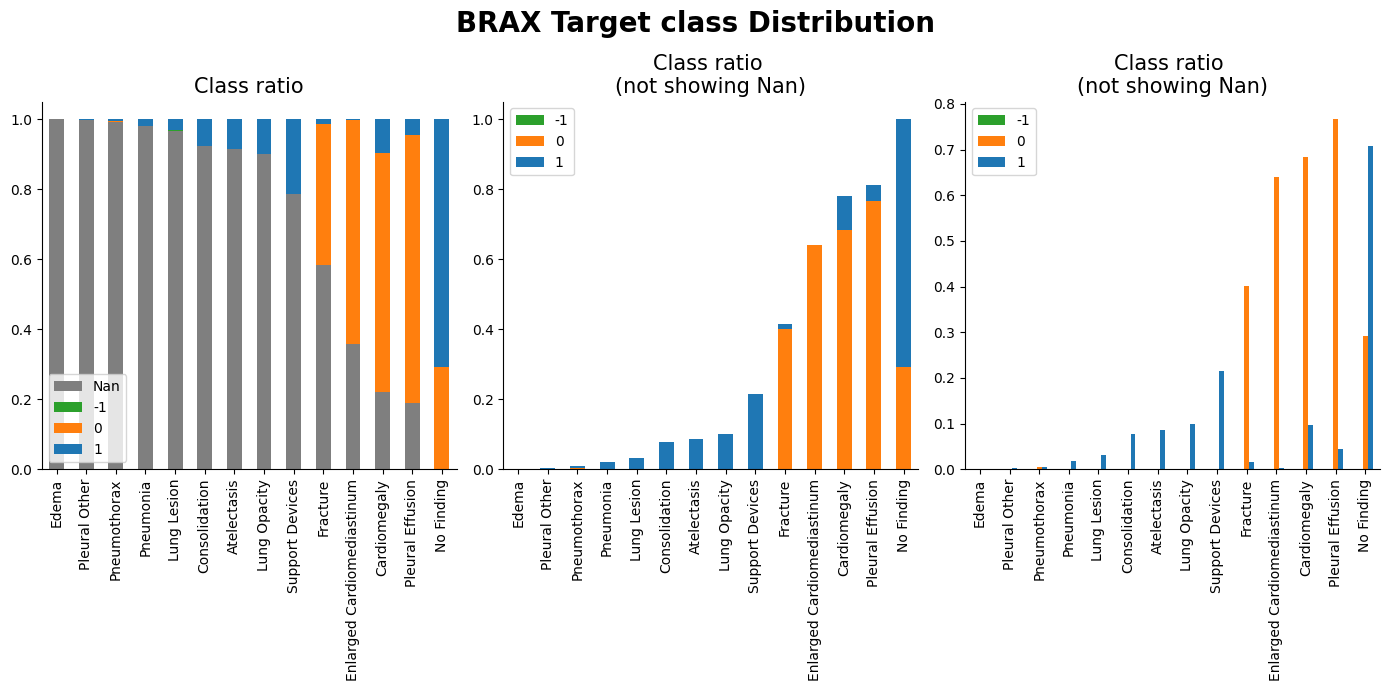

In [7]:
fig_lb_viz, ax_lb_viz = plt.subplots(1, 3, figsize=(14, 7))

calculate_label(df[target_cols], ratio=True, include_nan=True).sort_values('Nan', ascending=False).plot(
    kind='bar', stacked=True, ax=ax_lb_viz[0], color=['tab:gray','tab:green','tab:orange','tab:blue'])
order_by_nan_ratio = calculate_label(df[target_cols], ratio=True, include_nan=True).sort_values('Nan', ascending=False).index
calculate_label(df[target_cols], ratio=True, include_nan=False).loc[order_by_nan_ratio, :].plot(
    kind='bar', stacked=True, ax=ax_lb_viz[1], color=['tab:green','tab:orange','tab:blue'])
calculate_label(df[target_cols], ratio=True, include_nan=False).loc[order_by_nan_ratio, :].plot(
    kind='bar', stacked=False, ax=ax_lb_viz[2], color=['tab:green','tab:orange','tab:blue'])

ax_lb_viz[0].set_title('Class ratio', fontsize=15)
ax_lb_viz[1].set_title('Class ratio \n(not showing Nan)', fontsize=15)
ax_lb_viz[2].set_title('Class ratio \n(not showing Nan)', fontsize=15)

for ax in ax_lb_viz:
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

fig_lb_viz.suptitle('BRAX Target class Distribution', fontsize=20, fontweight='bold')
fig_lb_viz.tight_layout()

In [8]:
calculate_label(df[target_cols], ratio=False, include_nan=False).sort_values(by='0')

-1      0      1
Edema                        0      0     50
Pleural Other                0      1    117
Consolidation                0     19   3157
Support Devices              0     21   8791
Atelectasis                  0     41   3518
Lung Lesion                 19     46   1290
Pneumonia                    0     46    774
Lung Opacity                17     52   4065
Pneumothorax                 0    189    214
No Finding                   0  11958  29009
Fracture                     0  16405    624
Enlarged Cardiomediastinum   2  26212     71
Cardiomegaly                 0  28000   3984
Pleural Effusion             0  31422   1822

In [9]:
calculate_label(df[target_cols], ratio=True, include_nan=False).sort_values(by='0')

-1         0         1
Edema                       0.000000  0.000000  0.001220
Pleural Other               0.000000  0.000024  0.002856
Consolidation               0.000000  0.000464  0.077062
Support Devices             0.000000  0.000513  0.214587
Atelectasis                 0.000000  0.001001  0.085874
Lung Lesion                 0.000464  0.001123  0.031489
Pneumonia                   0.000000  0.001123  0.018893
Lung Opacity                0.000415  0.001269  0.099226
Pneumothorax                0.000000  0.004613  0.005224
No Finding                  0.000000  0.291893  0.708107
Fracture                    0.000000  0.400444  0.015232
Enlarged Cardiomediastinum  0.000049  0.639832  0.001733
Cardiomegaly                0.000000  0.683477  0.097249
Pleural Effusion            0.000000  0.767008  0.044475

##### Key observations
* Clearly, the nan is dominant in most of the target columns
  - Suppose nan is converted to 0, then every target column except 'No Findings' has much more 0 than 1
* There are few uncertain labels in Enlarged Cardiomediastinum, Lung Opacity, and Lung Lesion. The amounts of -1 are neglectable
* Interestingly, there are some columns that have much more positive (1) than negative (0) but it can be neutralized by the converting strategy of nan

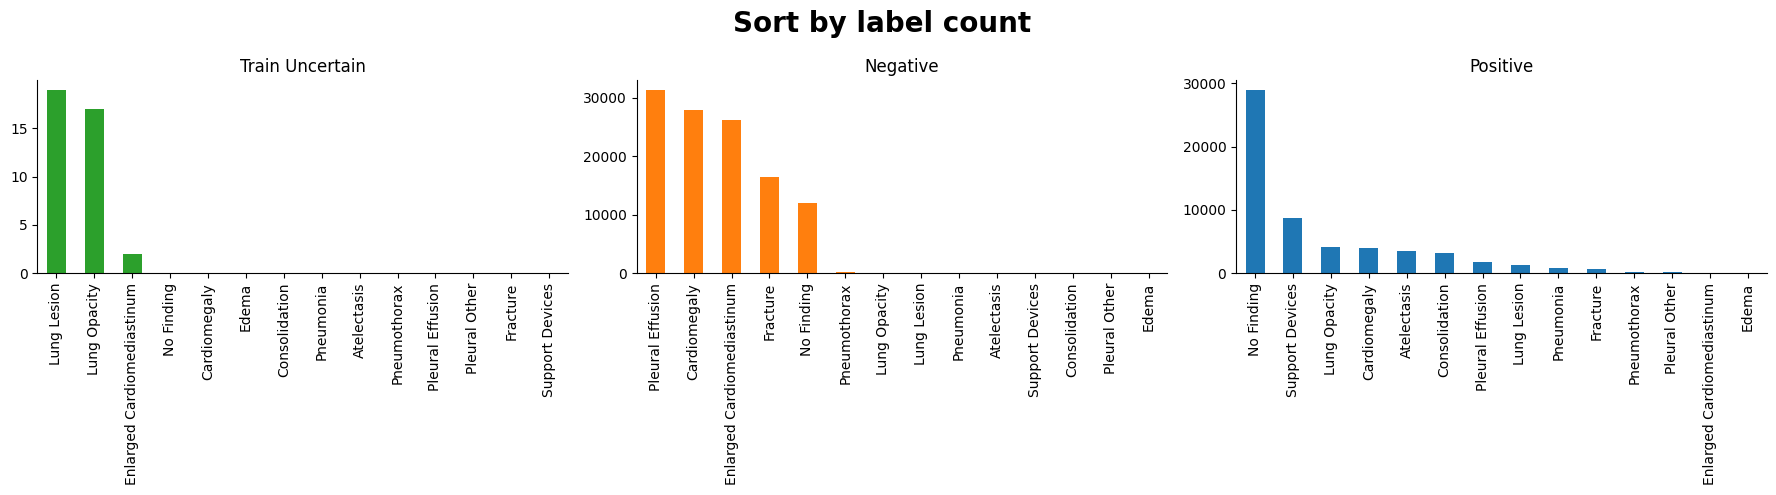

In [10]:
fig_val_sort, ax_val_sort = plt.subplots(1, 3, figsize=(18, 5))

calculate_label(df[target_cols], ratio=False, include_nan=False)['-1'].sort_values(ascending=False).plot(
    kind='bar', ax=ax_val_sort[0], title='Train Uncertain', color='tab:green')
calculate_label(df[target_cols], ratio=False, include_nan=False)['0'].sort_values(ascending=False).plot(
    kind='bar', ax=ax_val_sort[1], color='tab:orange', title='Negative')
calculate_label(df[target_cols], ratio=False, include_nan=False)['1'].sort_values(ascending=False).plot(
    kind='bar', ax=ax_val_sort[2], color='tab:blue', title='Positive')

for ax in ax_val_sort:
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

fig_val_sort.suptitle('Sort by label count', fontsize=20, fontweight='bold')
fig_val_sort.tight_layout()

## 1.4 Non-target column analysis

There are some valuable non-target columns in BRAX CSV file<br>
Although these columns are not directly related to the input or output, it is worth exploring them to understand data distribution<br>
The target columns are **PatientSex and PatientAge**

#### 1.4.1 Simple distribution check

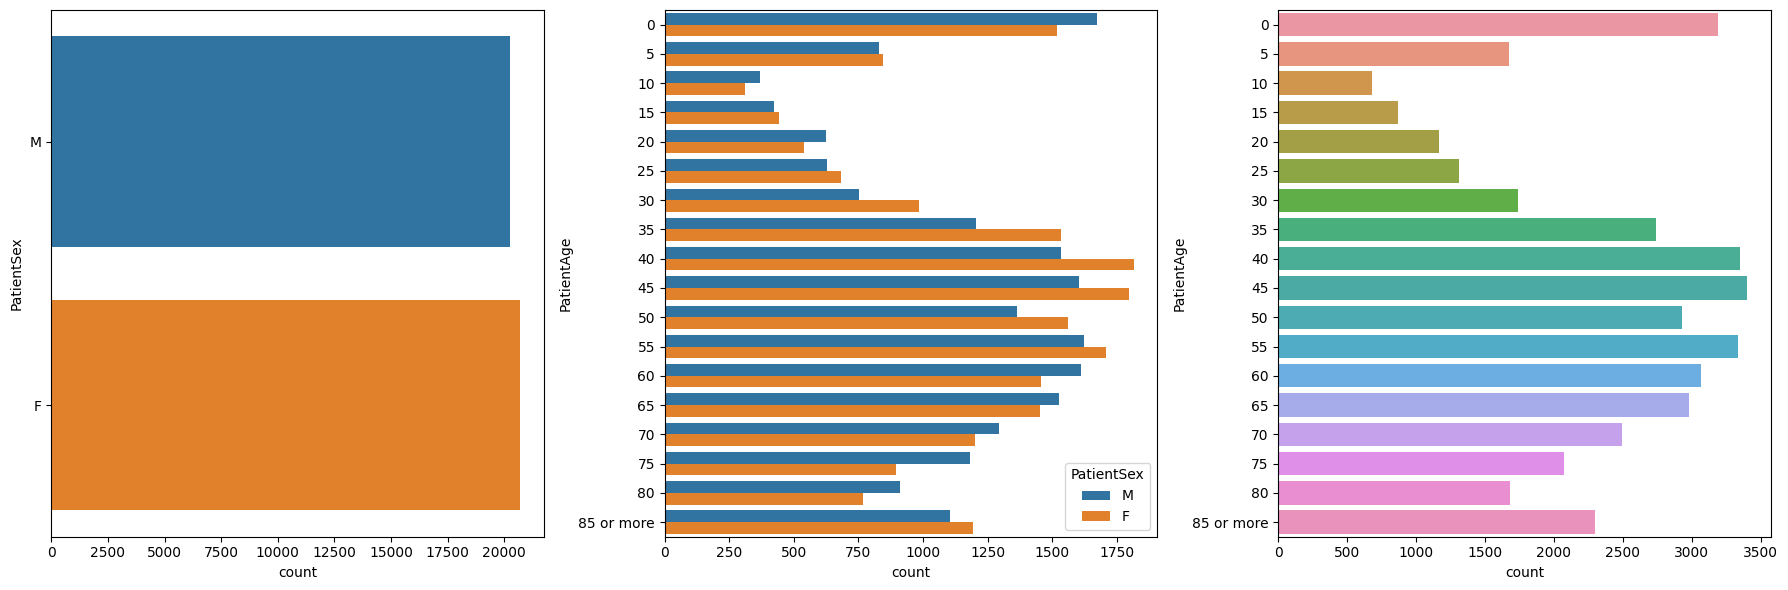

In [11]:
# To handle PatientAge column easily, the string value '85 or more' in PatientAge is changed to 85(int)
df2 = deepcopy(df)
df2.PatientAge = df2.PatientAge.replace('85 or more', 85).astype('int')
patient_age_org_lbs = ([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, '85 or more'])

fig_non_tgt, ax_non_tgt = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(df2, y='PatientSex', ax=ax_non_tgt[0])
sns.countplot(df2, y='PatientAge', ax=ax_non_tgt[2])
sns.countplot(df2, y='PatientAge', hue='PatientSex', ax=ax_non_tgt[1])

ax_non_tgt[1].set_yticklabels(patient_age_org_lbs)
ax_non_tgt[2].set_yticklabels(patient_age_org_lbs)

fig_non_tgt.tight_layout()

##### Key observations
* In terms of number of image samples, there is no bias in patients' sex
  - Patients' sex also evenly distributed by age group
  - Overall, patients' sex is not supposed to have much effect on distorting outcomes
* The BRAX contains not only the adults but also the infants and adolescents. It is quite important if one has a experimental subject which is sensitive to the patients' age
* Patients' age groups are not uniformly distributed. It rather shows a distribution similar to the normal distribution with high values on two side
  - Probably the broader coverage of '85 or more' is a plausible reason for its high value compared to the neighbor, but it is hard to find an explicit reason for the high value of age groups 0~4 and 5~9
  - Even considering that the Brazil is comparatively not aging society, the high number of the age group 0, 5 is something that should be addressed accoring to the the research topic
  - The demographics of Brazil data or domain knowledge in pediatrics might help to infer the reason for age distribution

#### 1.4.2 Further inspection of the reason for age group distribution

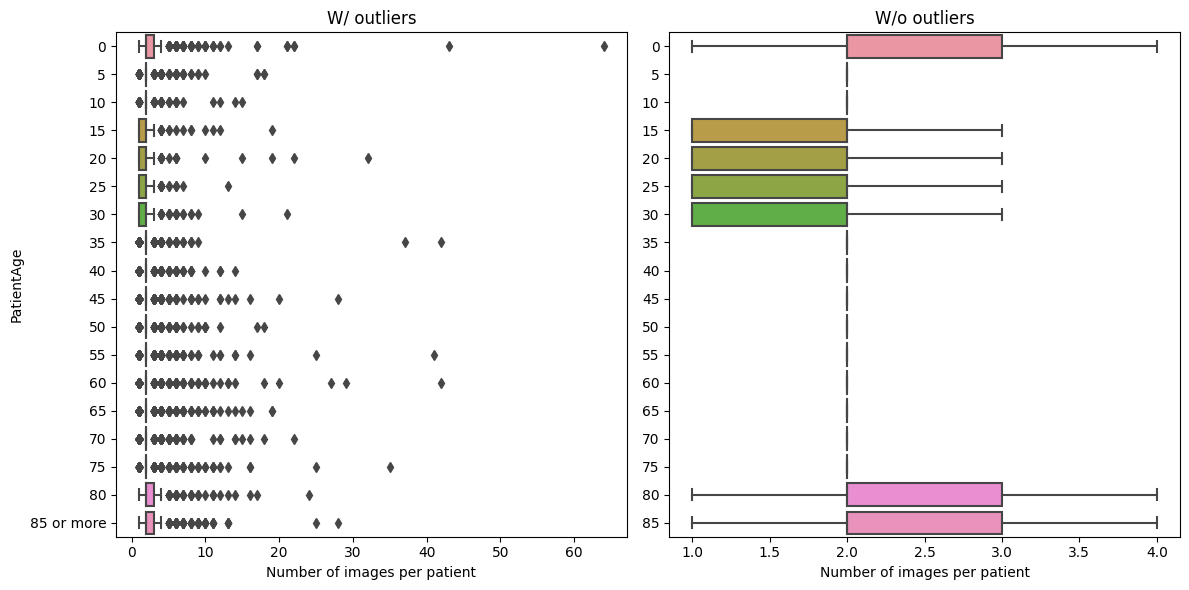

In [12]:
fig_img_per_patient, ax_img_per_patient = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(df2.groupby(['PatientID', 'PatientAge']).count()['DicomPath'].reset_index(), x='DicomPath', y='PatientAge', ax=ax_img_per_patient[0], orient='h')
sns.boxplot(df2.groupby(['PatientID', 'PatientAge']).count()['DicomPath'].reset_index(), x='DicomPath', y='PatientAge', ax=ax_img_per_patient[1], orient='h', showfliers=False)

ax_img_per_patient[0].set_xlabel('Number of images per patient')
ax_img_per_patient[0].set_yticklabels(patient_age_org_lbs)
ax_img_per_patient[0].set_title('W/ outliers')
ax_img_per_patient[1].set_ylabel('')
ax_img_per_patient[1].set_title('W/o outliers')
ax_img_per_patient[1].set_xlabel('Number of images per patient')

fig_img_per_patient.tight_layout()

##### Key observations
* The average number of images per patient is around 2 in most age groups
* All age groups have outlier patients who have far more images than others
  - The age group 0 (age 0<=x<5) has the maximum valued outlier but it is not sufficient to confirm <br>whether the outlier is the key reason for the comparatively high value of age group 0 in terms of the number of image samples

## 1.5 Target balance in terms of view point 

### 1.5.1 Simple distribution check

In [13]:
df['ViewPosition'].fillna('Missing').value_counts()

PA          13960
Missing     11260
L            9052
AP           5349
RL           1340
LT-DECUB        3
RLO             2
AP LLD          1
Name: ViewPosition, dtype: int64

In [14]:
df['ViewPosition'].fillna('Missing').value_counts()/len(df)

PA          0.340762
Missing     0.274855
L           0.220958
AP          0.130569
RL          0.032709
LT-DECUB    0.000073
RLO         0.000049
AP LLD      0.000024
Name: ViewPosition, dtype: float64

##### Key observations
* There are quite specific classes about view position but it could be integrated into two class frontal & lateral
  - There are some view position classes with very few number but since the scale is too small, neglecting it might not distort the distribution
* The problem is high proportion of missing values. More than quarter of view positions are missing.<br>It might be a problem or time consuming task if the view position is important feature for the research subject

#### 1.5.2 Simplifying view positions

In [15]:
df3 = deepcopy(df)
df3['ViewPosition'] = df3['ViewPosition'].fillna('Missing').map(
    {
        'PA': 'Frontal',
        'AP': 'Frontal',
        'AP LLD': 'Frontal',
        'L': 'Lateral',
        'RL': 'Lateral',
        'LT-DECUB': 'Lateral',
        'RLO': 'Lateral',
        'Missing':'Missing',
    }
)
df3['ViewPosition'].value_counts()

Frontal    19310
Missing    11260
Lateral    10397
Name: ViewPosition, dtype: int64

##### Key observations
* The ratio about Frontal, Lateral, and Missing is about 2:1:1. The real distribution is heavily depended on the missing values
* Since the missing value occupies a lot, it could be wise to find a way to label it if the view position is important


# 2. Explore Images

## 2.1 Image random sampling by each dataset

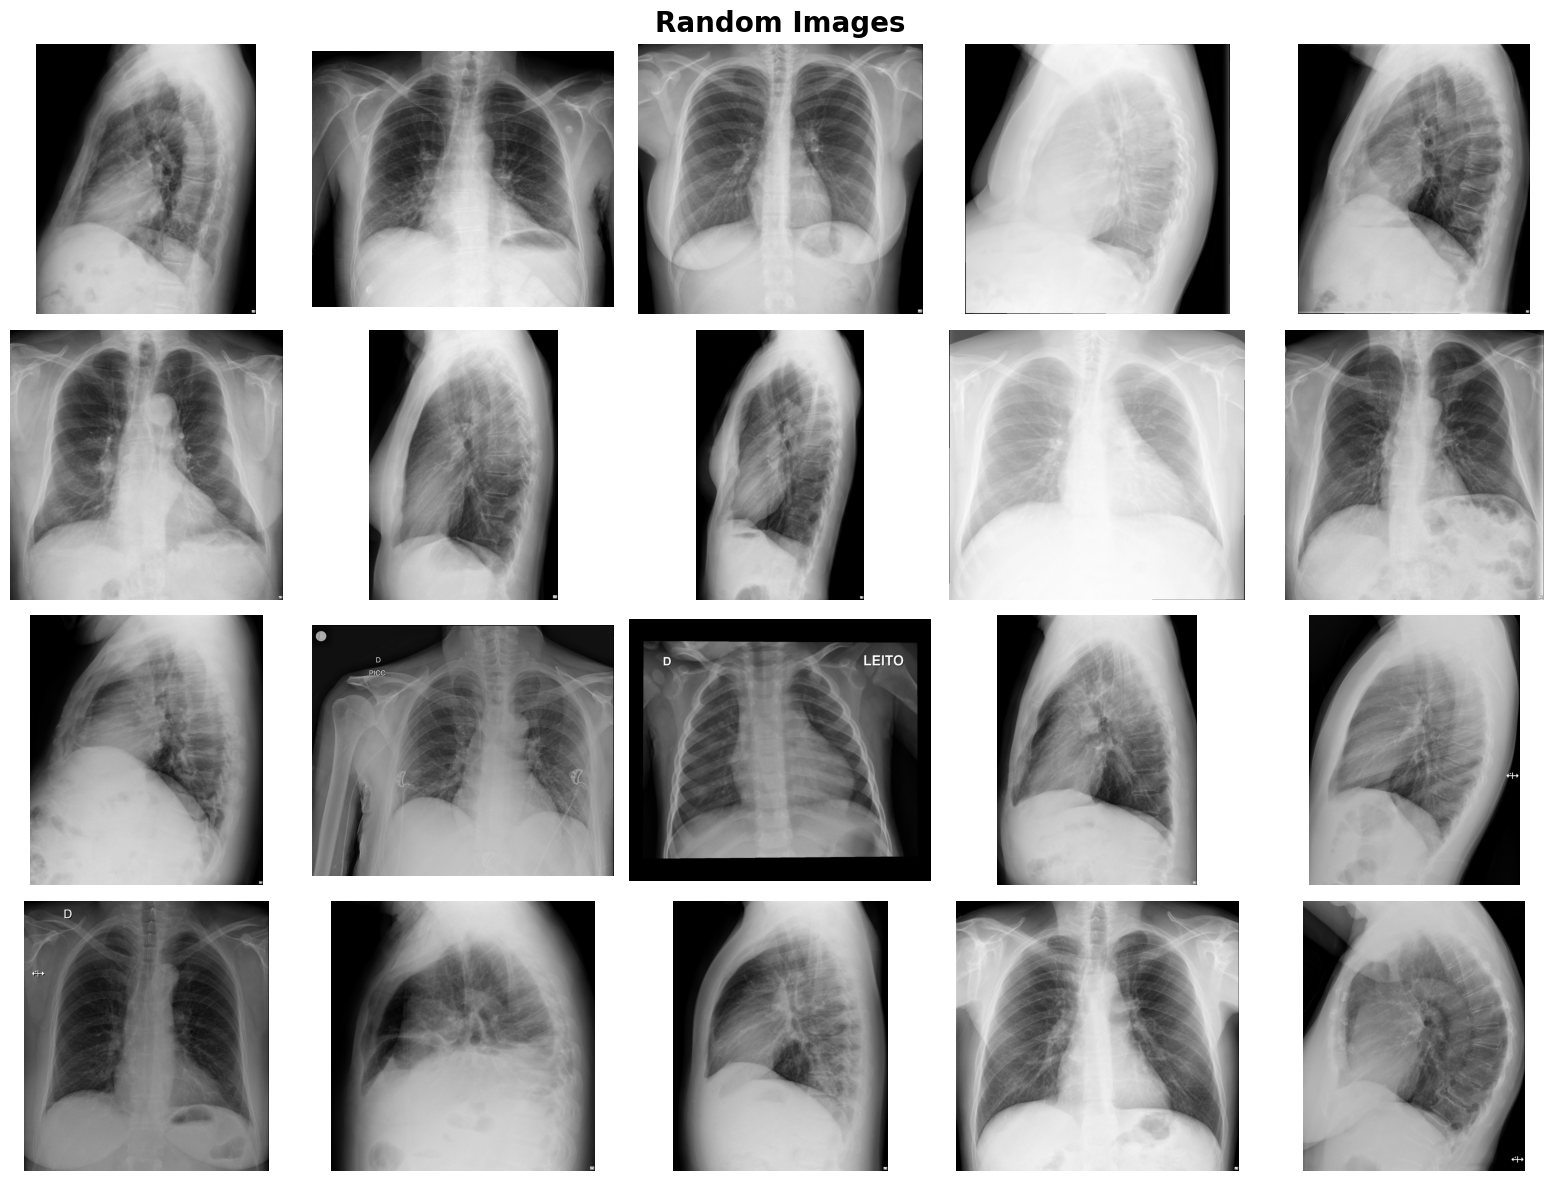

In [16]:
def plot_random_images(root_path, df, title=None, view_point=None, random_state=42):
    fig, axes = plt.subplots(4, 5, figsize=(16, 12))

    axes = axes.flatten()
    if view_point:
        df_w_vp = df[df['ViewPosition']==view_point]
        img_paths = df_w_vp.PngPath.sample(20, random_state=random_state).values
    else:
        img_paths = df.PngPath.sample(20, random_state=random_state).values

    for idx, ax in enumerate(axes):
        try:
            img = Image.open(os.path.join(root_path, img_paths[idx]))
        except:
            img = Image.open(os.path.join(root_path, 'CheXpert', img_paths[idx]))
        ax.imshow(img, cmap='gray')
        ax.axis(False)

    fig.suptitle(title, fontsize=20, weight='bold')
    fig.tight_layout()

plot_random_images(root_dir, df3, 'Random Images', random_state=0)

##### Key observations
* Some images have strings (a word or a letter) in the image
* Some images are comparatively brighter than the others
* There is a image with thicker frame (the center image above)

## 2.2 View position check by random sampling

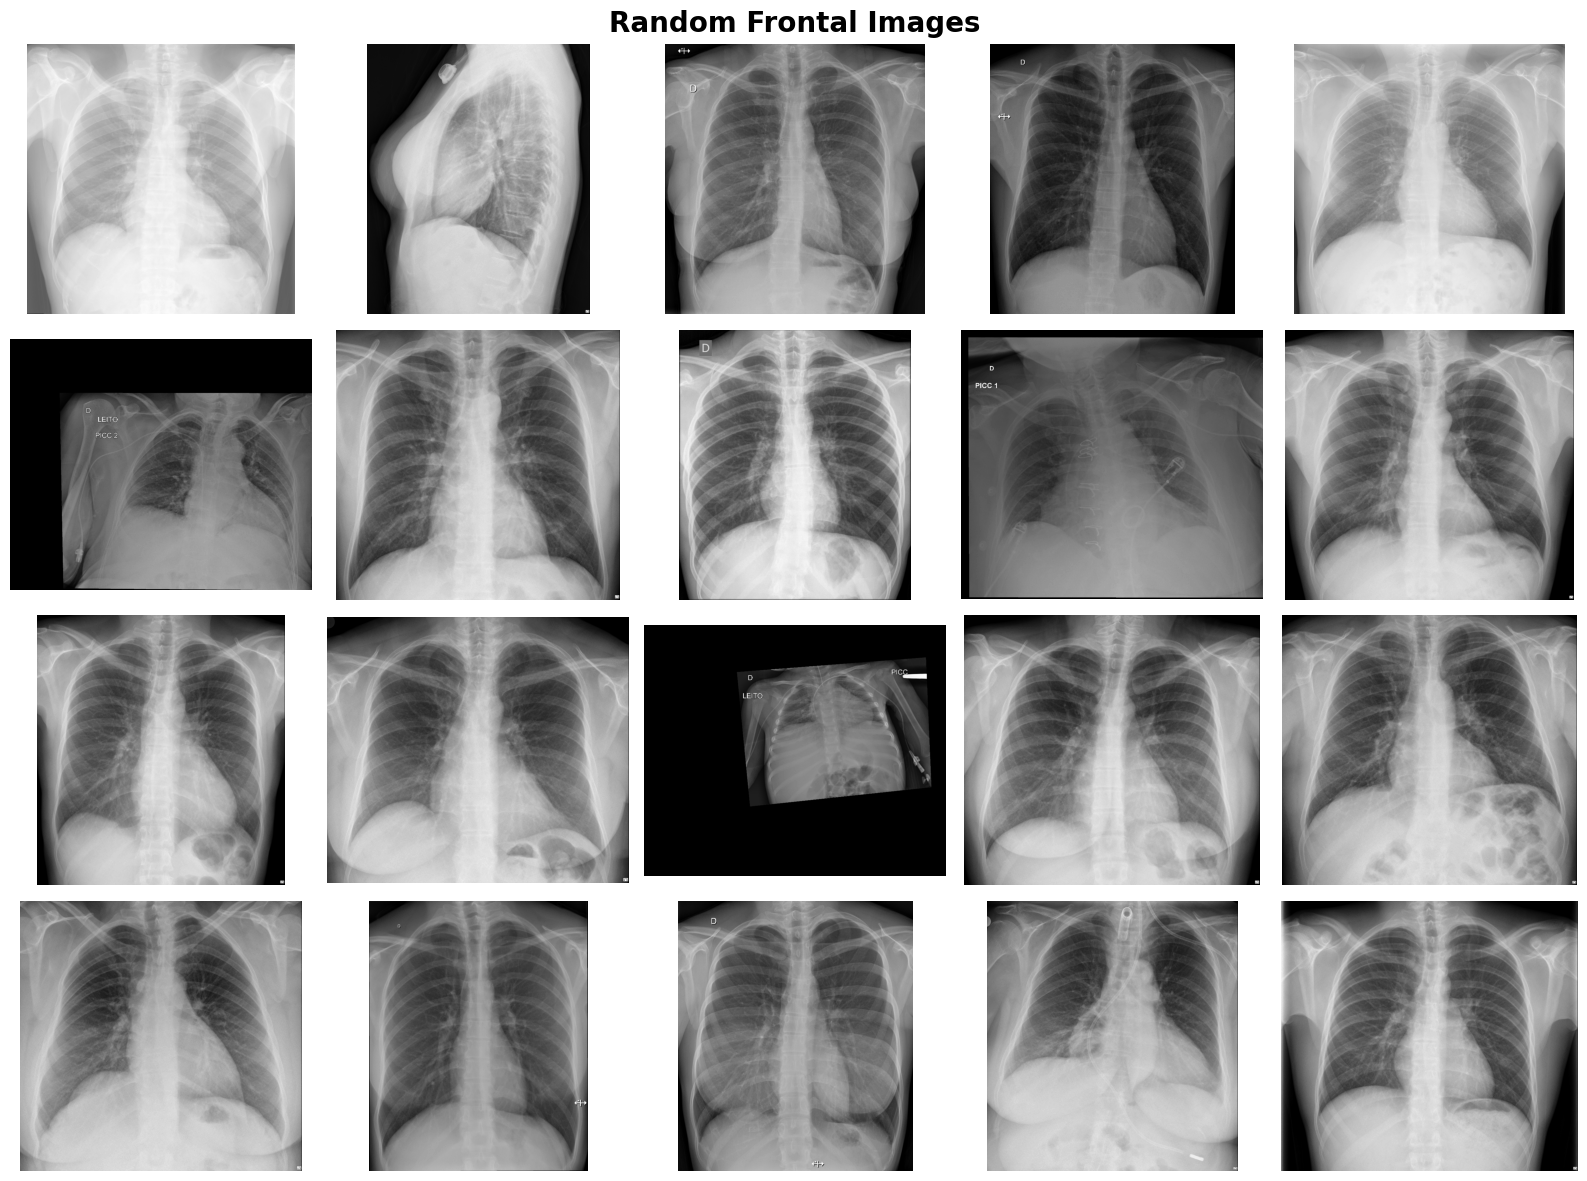

In [17]:
vp_seed = 0
plot_random_images(root_dir, df3, 'Random Frontal Images', 'Frontal', random_state=vp_seed)

##### Key observations
* There is a mislabeled image (row1, column2). If the research subject is sensitive to this, relabeling should be considered
* Some images are not centered (row2, column1 or row3, column3). Also, the image (3, 3) is too small compared to the others. This type of image might need adequate preprocessing such as image augmentation or removal

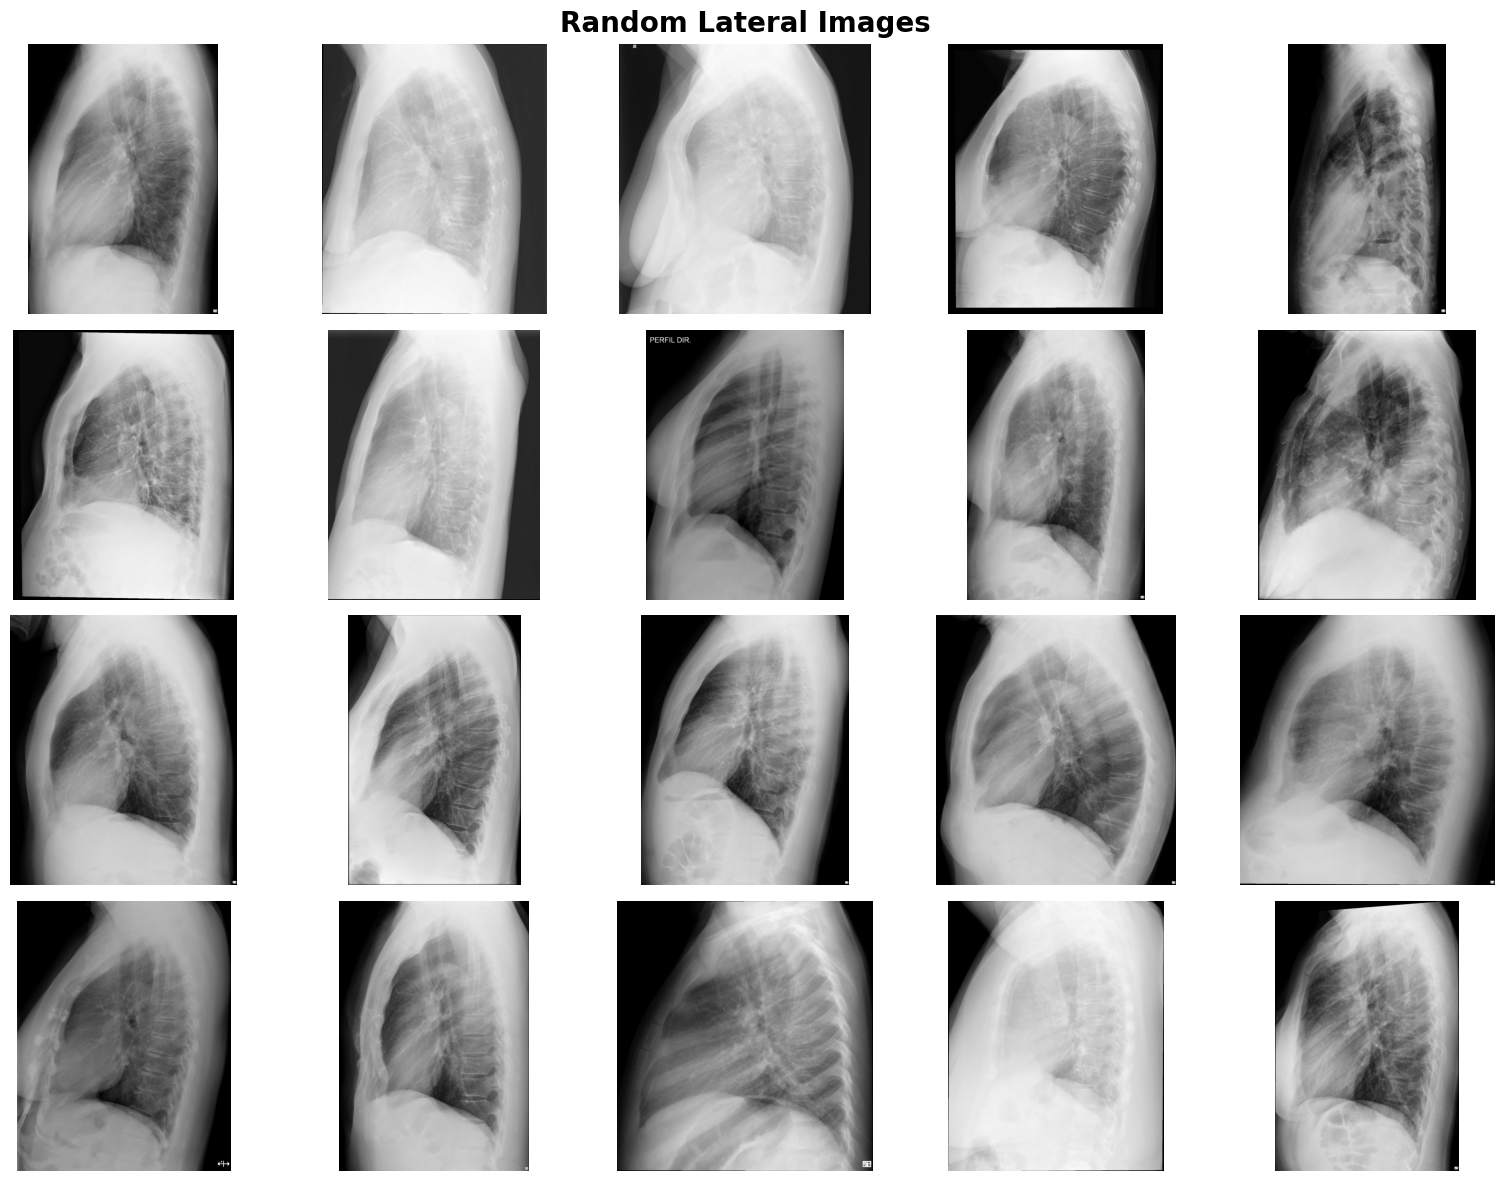

In [18]:
plot_random_images(root_dir, df3, 'Random Lateral Images', 'Lateral', random_state=vp_seed)

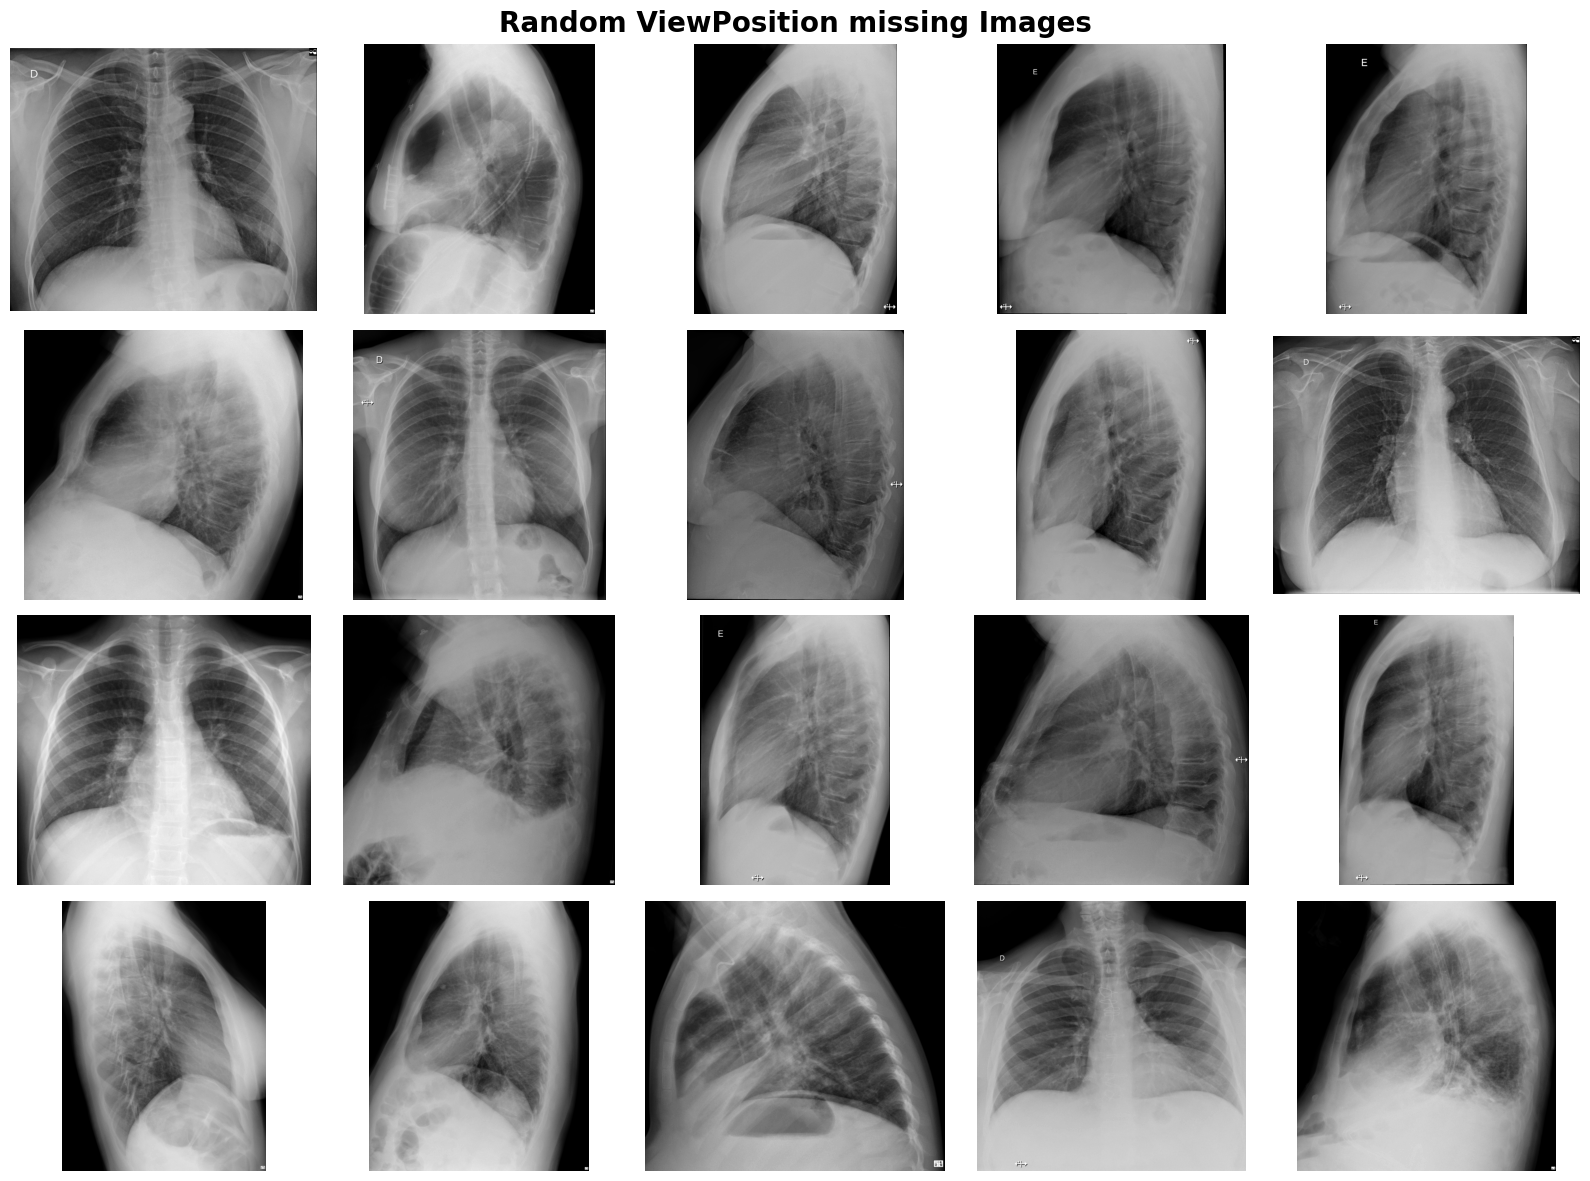

In [19]:
plot_random_images(root_dir, df3, 'Random ViewPosition missing Images', 'Missing', random_state=vp_seed)

##### Key observations
* It is hard to guarantee with this small number of samples, but we can suspect there are more lateral images than frontal images among missing view position data
  - Without missing the ratio between frontal:lateral is about 2:1 but if there are more lateral view images in missing view position, the real ratio between two classes would be smaller than 2:1. Thus, restricting view position can heavily affect data size